In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sko.DE import DE
import matplotlib.pyplot as plt

In [17]:
df = pd.read_csv('dataset.csv')
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))
df.set_index('Date', inplace=True)
df.drop(columns=['Year', 'Month'], inplace=True)

In [18]:
n_lags = 5

for i in range(1, n_lags + 1):
    df[[f'Hydroelectric Power_lag{i}', f'Geothermal Energy_lag{i}', f'Solar Energy_lag{i}', 
        f'Wind Energy_lag{i}', f'Wood Energy_lag{i}', f'Waste Energy_lag{i}', 
        f'Fuel Ethanol, Excluding Denaturant_lag{i}']] = df[['Hydroelectric Power', 'Geothermal Energy', 
                                                            'Solar Energy', 'Wind Energy', 'Wood Energy', 
                                                            'Waste Energy', 'Fuel Ethanol, Excluding Denaturant']].shift(i)

df.dropna(inplace=True)

X = df.drop(columns=['Hydroelectric Power', 'Geothermal Energy', 'Solar Energy', 
                    'Wind Energy', 'Wood Energy', 'Waste Energy', 'Fuel Ethanol, Excluding Denaturant'])
y = df[['Hydroelectric Power', 'Geothermal Energy', 'Solar Energy', 
       'Wind Energy', 'Wood Energy', 'Waste Energy', 'Fuel Ethanol, Excluding Denaturant']]

scaler_y = MinMaxScaler()
y_scaled = pd.DataFrame(scaler_y.fit_transform(y), columns=y.columns, index=y.index)

In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X.select_dtypes(include=['float64', 'int64']).columns),
        ('cat', OneHotEncoder(), X.select_dtypes(include=['object', 'category']).columns)
    ])

def create_pipeline(hidden_layer_size, activation_function, learning_rate, alpha, momentum):
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', MLPRegressor(hidden_layer_sizes=(hidden_layer_size,), activation=activation_function, 
                                   learning_rate_init=learning_rate, alpha=alpha, momentum=momentum, 
                                   max_iter=3000, random_state=42))
    ])

def objective_function(params):
    hidden_layer_size = int(params[0])
    learning_rate = params[1]
    alpha = params[2]
    momentum = params[3]
    activation_function = 'tanh' if params[4] < 0.5 else 'logistic'
    n_lags = int(params[5])

    df_lagged = df.copy()
    for i in range(1, n_lags + 1):
        df_lagged[[f'Hydroelectric Power_lag{i}', f'Geothermal Energy_lag{i}', f'Solar Energy_lag{i}', 
                   f'Wind Energy_lag{i}', f'Wood Energy_lag{i}', f'Waste Energy_lag{i}', 
                   f'Fuel Ethanol, Excluding Denaturant_lag{i}']] = df_lagged[['Hydroelectric Power', 'Geothermal Energy', 
                                                                               'Solar Energy', 'Wind Energy', 'Wood Energy', 
                                                                               'Waste Energy', 'Fuel Ethanol, Excluding Denaturant']].shift(i)
    df_lagged.dropna(inplace=True)
    X = df_lagged.drop(columns=['Hydroelectric Power', 'Geothermal Energy', 'Solar Energy', 
                                'Wind Energy', 'Wood Energy', 'Waste Energy', 'Fuel Ethanol, Excluding Denaturant'])
    y_scaled = pd.DataFrame(scaler_y.transform(df_lagged[['Hydroelectric Power', 'Geothermal Energy', 'Solar Energy', 
                                                          'Wind Energy', 'Wood Energy', 'Waste Energy', 'Fuel Ethanol, Excluding Denaturant']]), 
                            columns=y.columns, index=df_lagged.index)

    pipeline = create_pipeline(hidden_layer_size, activation_function, learning_rate, alpha, momentum)

    tscv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_scaled.iloc[train_index], y_scaled.iloc[test_index]

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))
        rmse_scores.append(np.mean(rmse))

    avg_rmse = np.mean(rmse_scores)
    return avg_rmse


In [20]:
lb = [1, 0.001, 1e-5, 0.5, 0, 3]
ub = [50, 0.1, 1e-3, 0.99, 1, 5]

de = DE(func=objective_function, n_dim=6, size_pop=50, max_iter=200, lb=lb, ub=ub, prob_mut=0.5, F=0.5)

In [21]:
best_params, best_value = de.run()

In [22]:
optimal_hidden_layer_size = int(best_params[0])
optimal_learning_rate = best_params[1]
optimal_alpha = best_params[2]
optimal_momentum = best_params[3]
optimal_activation_function = 'tanh' if best_params[4] < 0.5 else 'logistic'
optimal_n_lags = int(best_params[5])

print(f'Optimal Hidden Layer Size: {optimal_hidden_layer_size}')
print(f'Optimal Learning Rate: {optimal_learning_rate}')
print(f'Optimal Alpha: {optimal_alpha}')
print(f'Optimal Momentum: {optimal_momentum}')
print(f'Optimal Activation Function: {optimal_activation_function}')
print(f'Optimal Number of Lags: {optimal_n_lags}')

Optimal Hidden Layer Size: 20
Optimal Learning Rate: 0.039142990387802945
Optimal Alpha: 0.000999999606214764
Optimal Momentum: 0.787502832989595
Optimal Activation Function: logistic
Optimal Number of Lags: 4


In [23]:
for i in range(1, optimal_n_lags + 1):
    df[[f'Hydroelectric Power_lag{i}', f'Geothermal Energy_lag{i}', f'Solar Energy_lag{i}', 
        f'Wind Energy_lag{i}', f'Wood Energy_lag{i}', f'Waste Energy_lag{i}', 
        f'Fuel Ethanol, Excluding Denaturant_lag{i}']] = df[['Hydroelectric Power', 'Geothermal Energy', 
                                                            'Solar Energy', 'Wind Energy', 'Wood Energy', 
                                                            'Waste Energy', 'Fuel Ethanol, Excluding Denaturant']].shift(i)
df.dropna(inplace=True)
X = df.drop(columns=['Hydroelectric Power', 'Geothermal Energy', 'Solar Energy', 
                    'Wind Energy', 'Wood Energy', 'Waste Energy', 'Fuel Ethanol, Excluding Denaturant'])
y_scaled = pd.DataFrame(scaler_y.transform(df[['Hydroelectric Power', 'Geothermal Energy', 'Solar Energy', 
                                              'Wind Energy', 'Wood Energy', 'Waste Energy', 'Fuel Ethanol, Excluding Denaturant']]), 
                        columns=y.columns, index=df.index)


In [24]:
optimal_pipeline = create_pipeline(optimal_hidden_layer_size, optimal_activation_function, optimal_learning_rate, optimal_alpha, optimal_momentum)

train_index, test_index = list(TimeSeriesSplit(n_splits=5).split(X))[-1]
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y_scaled.iloc[train_index], y_scaled.iloc[test_index]

In [25]:
optimal_pipeline.fit(X_train, y_train)
y_pred = optimal_pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))
avg_rmse = np.mean(rmse)

print(f'Optimal Model RMSE for each target variable: {rmse}')
print(f'Optimal Model Average RMSE: {avg_rmse}')

Optimal Model RMSE for each target variable: [0.08109218 0.06552494 0.14859968 0.09437519 0.10668619 0.06552032
 0.05700086]
Optimal Model Average RMSE: 0.08839990831495403


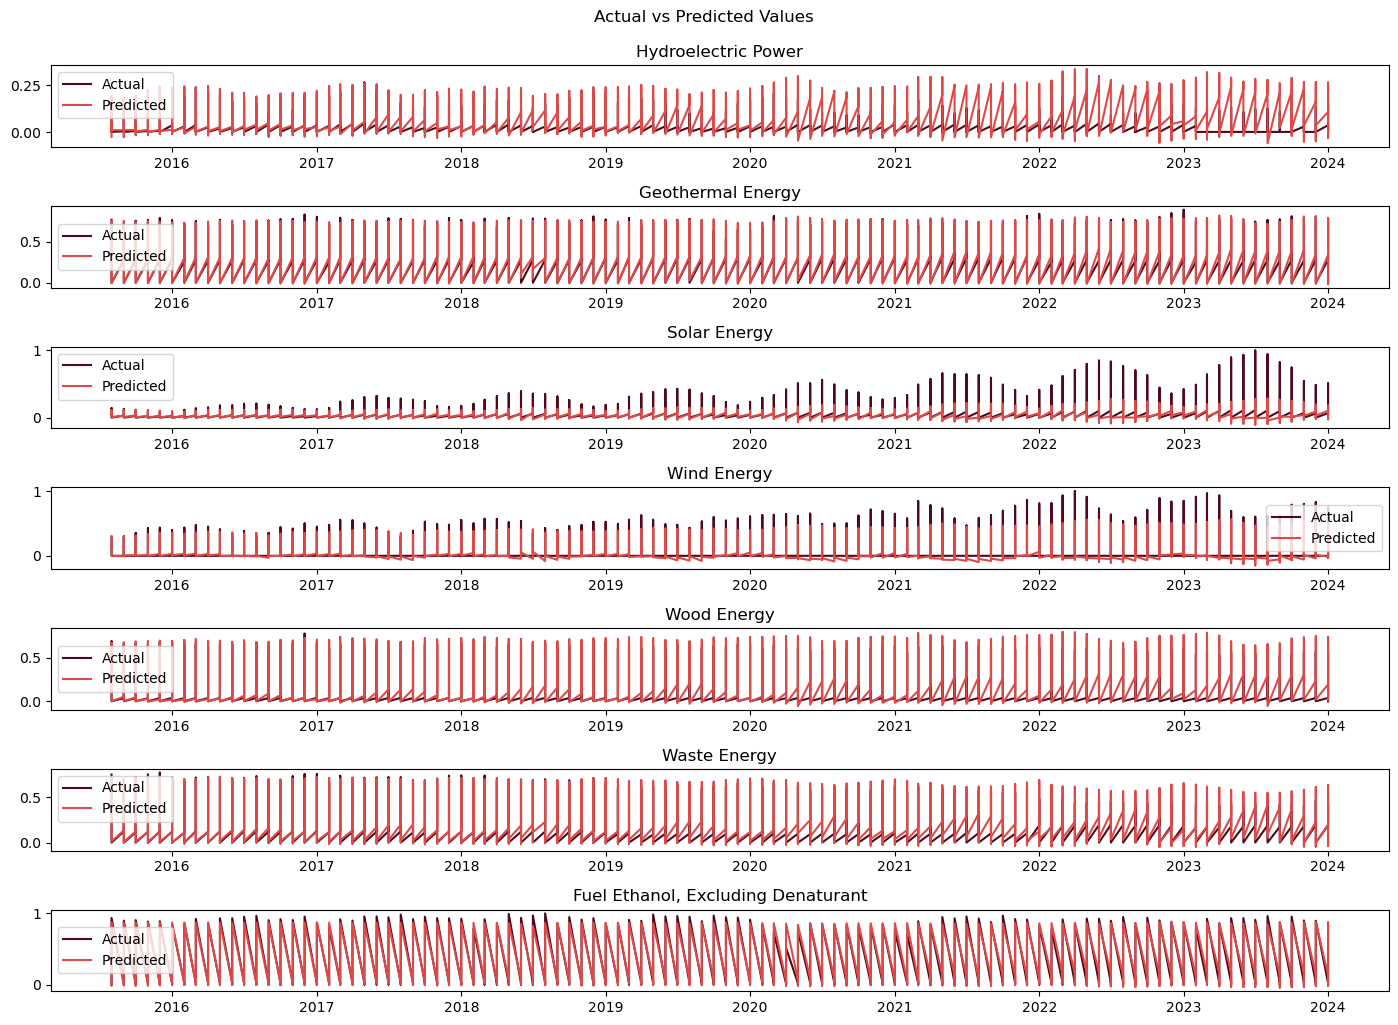

In [26]:
def plot_predictions(y_true, y_pred, columns, title):
    plt.figure(figsize=(14, 10))
    for i, column in enumerate(columns):
        plt.subplot(len(columns), 1, i + 1)
        plt.plot(y_true.index, y_true[column], label='Actual', color='#4F091D')
        plt.plot(y_true.index, y_pred[:, i], label='Predicted', color='#DD4A48')
        plt.title(column)
        plt.legend()
    plt.tight_layout()
    plt.suptitle(title, y=1.02)
    plt.show()

plot_predictions(y_test, y_pred, y.columns, 'Actual vs Predicted Values')